# #9 Min-Variance Portfolio

1. 최소-분산 포트폴리오를 구하고 그래프로 그려본다.
2. method using `minimize` in `scipy.optimize`
3. Min-Var portfolio w/ colorbar describing Sharpe ratio
4. pypfopt 패키지와 pulp를 이용하는 방법
5. pyptopt 와 DiscreteAllocation로 min-var/max-Sharpe ratio 포트폴리오의 자산 배분 비율과 그 값을 출력하고 barh()로 plot
6. `pypfopt`를 통해 efficient frontier/min-variance & max-Sharpe ratio portfolio + CML 구축, plot 및 backtest

## 1. 최소-분산 포트폴리오를 구하고 그래프로 그려본다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# import cvxopt as opt
# from cvxoppt import solvers
# solvers.options['show_progress'] = False

In [ ]:
tickers = ['AAPL', 'GOOGL', 'AMZN']
df = yf.download(tickers, start='2019-01-01')['Adj Close']

ret = df.pct_change(1).dropna()
ret.head()

[*********************100%***********************]  3 of 3 completed


,AAPL,AMZN,GOOGL
Date,,,
2019-01-03,-0.099607,-0.025241,-0.027696
2019-01-04,0.042689,0.050064,0.051294
2019-01-07,-0.002226,0.034353,-0.001994
2019-01-08,0.019063,0.016612,0.008783
2019-01-09,0.016982,0.001714,-0.003427


In [ ]:
ret_mtx = ret.values.T
ret_mtx

array([[-0.09960744,  0.0426892 , -0.00222581, ..., -0.00585988,
         0.00048668, -0.0056753 ],
       [-0.0252415 ,  0.050064  ,  0.03435341, ..., -0.01274489,
         0.00231095, -0.00755285],
       [-0.02769565,  0.05129358, -0.00199427, ..., -0.012471  ,
        -0.00348094, -0.02071483]])

In [ ]:
# generate random weights
def rand_weights(n):
    i = np.random.rand(n)
    return i / sum(i)

# generate a random portfolio
def rand_portfolio(returns):
    '''
    returns the mean & std_dev of a random portfolio returns
    '''
    r = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))

    mean = w * r.T
    variance = np.sqrt(w * C * w.T)

    # this recursion reduces outliers to make plots pretty
    if variance > 2:
        return rand_portfolio(returns)

    return mean, variance, w

제대로 동작하는지 체크:

In [ ]:
m, v, w = rand_portfolio(ret_mtx)
print(m, v, w)

[[0.00096979]] [[0.01909099]] [[0.21336026 0.45904607 0.32759367]]


In [ ]:
w.sum()

1.0

In [ ]:
portfolios = []
for i in range(500):
    m, s, w = rand_portfolio(ret_mtx)

In [ ]:
means = port_ret_var

## 2. method using `minimize` in `scipy.optimize`:

scipy.optimize의 minimize를 이용하고(method='SLSQP') weight에 대한 적절한 constraints와 bounds를 설정하여

min-variance portfolio (최소-분산 포트폴리오)를 plot한다:

[*********************100%***********************]  3 of 3 completed


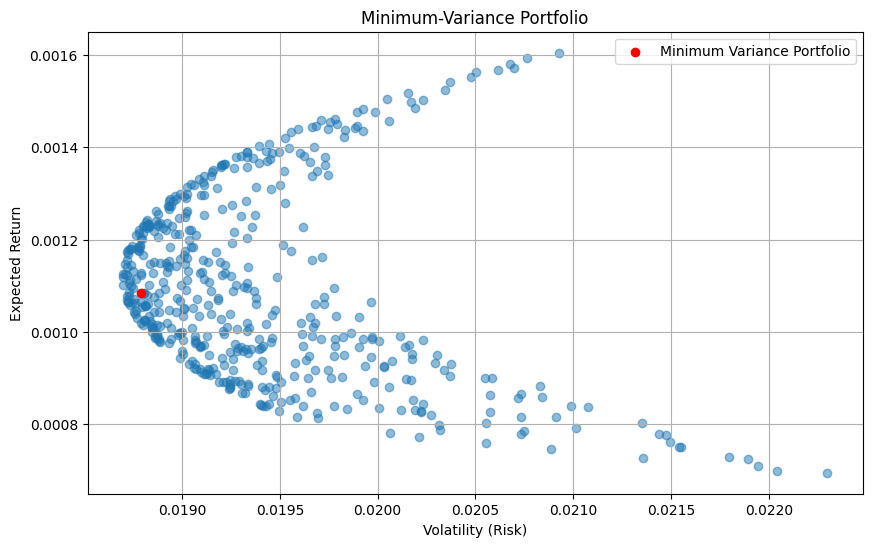

Minimum Variance Portfolio:
Weights: [0.33333333 0.33333333 0.33333333]
Expected Return: 0.0010843609173264964
Volatility: 0.018790403102529944


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tickers = ['AAPL', 'GOOGL', 'AMZN']
df = yf.download(tickers, start='2019-01-01')['Adj Close']
returns = df.pct_change(1).dropna()

# 공분산 행렬 계산
cov_matrix = returns.cov()

# 포트폴리오 종목 비중 초기화: uniform weights로
num_assets = len(returns.columns)
weights = np.ones(num_assets) / num_assets

# 최적화 함수로 최소 분산 포트폴리오 계산
from scipy.optimize import minimize

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # 비중 합계는 1
bounds = tuple((0, 1) for _ in range(num_assets))  # 각 비중은 0과 1 사이

result = minimize(portfolio_variance, weights, args=(cov_matrix,),
                  method='SLSQP', constraints=constraints, bounds=bounds)

optimal_weights = result.x
min_variance = result.fun

# 최소 분산 포트폴리오 수익률 계산
expected_returns = returns.mean()
min_portfolio_return = np.dot(expected_returns, optimal_weights)

# 포트폴리오 시뮬레이션
n_simulations = 500
returns_simulated = np.zeros(n_simulations)
volatility_simulated = np.zeros(n_simulations)

for i in range(n_simulations):
    weights_simulated = np.random.dirichlet(np.ones(num_assets), size=1).flatten()
    returns_simulated[i] = np.dot(expected_returns, weights_simulated)
    volatility_simulated[i] = np.sqrt(portfolio_variance(weights_simulated, cov_matrix))

# 최소 분산 포트폴리오 그래프
plt.figure(figsize=(10, 6))
plt.scatter(volatility_simulated, returns_simulated, marker='o', alpha=0.5)
plt.scatter(np.sqrt(min_variance), min_portfolio_return, marker='o', color='red', label='Minimum Variance Portfolio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.title('Minimum-Variance Portfolio')
plt.legend()
plt.grid(True)
plt.show()

# Print minimum variance portfolio details
print('Minimum Variance Portfolio:')
print('Weights:', optimal_weights)
print('Expected Return:', min_portfolio_return)
print('Volatility:', np.sqrt(min_variance))

[*********************100%***********************]  3 of 3 completed


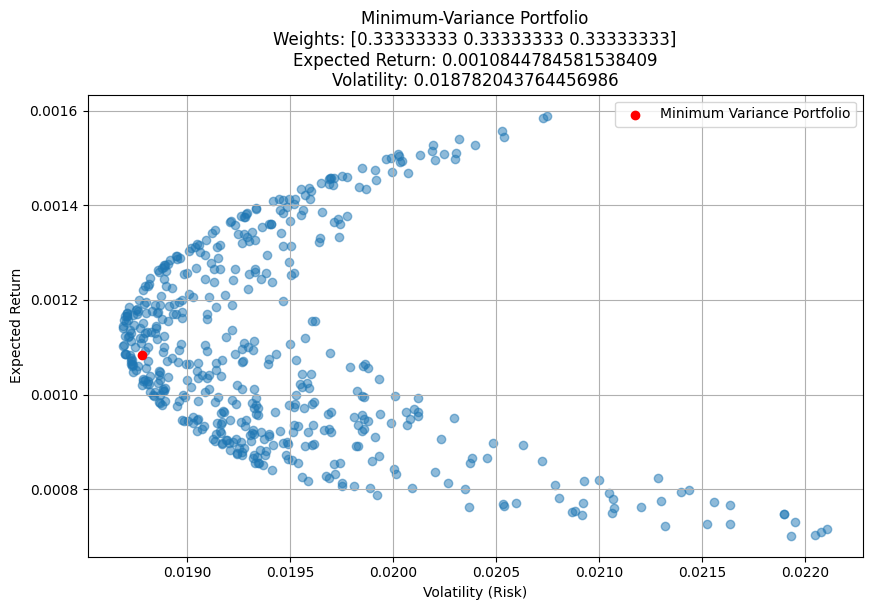

In [ ]:
# 위 코드에서 plt.title 부분만 수정했다:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tickers = ['AAPL', 'GOOGL', 'AMZN']
df = yf.download(tickers, start='2019-01-01')['Adj Close']
returns = df.pct_change(1).dropna()

# 공분산 행렬 계산
cov_matrix = returns.cov()

# 포트폴리오 종목 비중 초기화: uniform weights로
num_assets = len(returns.columns)
weights = np.ones(num_assets) / num_assets

# 최적화 함수로 최소 분산 포트폴리오 계산
from scipy.optimize import minimize

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # 비중 합계는 1
bounds = tuple((0, 1) for _ in range(num_assets))  # 각 비중은 0과 1 사이

result = minimize(portfolio_variance, weights, args=(cov_matrix,),
                  method='SLSQP', constraints=constraints, bounds=bounds)

optimal_weights = result.x
min_variance = result.fun

# 최소 분산 포트폴리오 수익률 계산
expected_returns = returns.mean()
min_portfolio_return = np.dot(expected_returns, optimal_weights)

# 포트폴리오 시뮬레이션
n_simulations = 500
returns_simulated = np.zeros(n_simulations)
volatility_simulated = np.zeros(n_simulations)

for i in range(n_simulations):
    weights_simulated = np.random.dirichlet(np.ones(num_assets), size=1).flatten()
    returns_simulated[i] = np.dot(expected_returns, weights_simulated)
    volatility_simulated[i] = np.sqrt(portfolio_variance(weights_simulated, cov_matrix))

# 최소 분산 포트폴리오 그래프
plt.figure(figsize=(10, 6))
plt.scatter(volatility_simulated, returns_simulated, marker='o', alpha=0.5)
plt.scatter(np.sqrt(min_variance), min_portfolio_return, marker='o', color='red', label='Minimum Variance Portfolio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')

# 수정된 부분: optimal_weights, min_portfolio_return, np.sqrt(min_variance) 출력
title = f"Minimum-Variance Portfolio\nWeights: {optimal_weights}\nExpected Return: {min_portfolio_return}\nVolatility: {np.sqrt(min_variance)}"
plt.title(title)

plt.legend()
plt.grid(True)
plt.show()

[*********************100%***********************]  3 of 3 completed


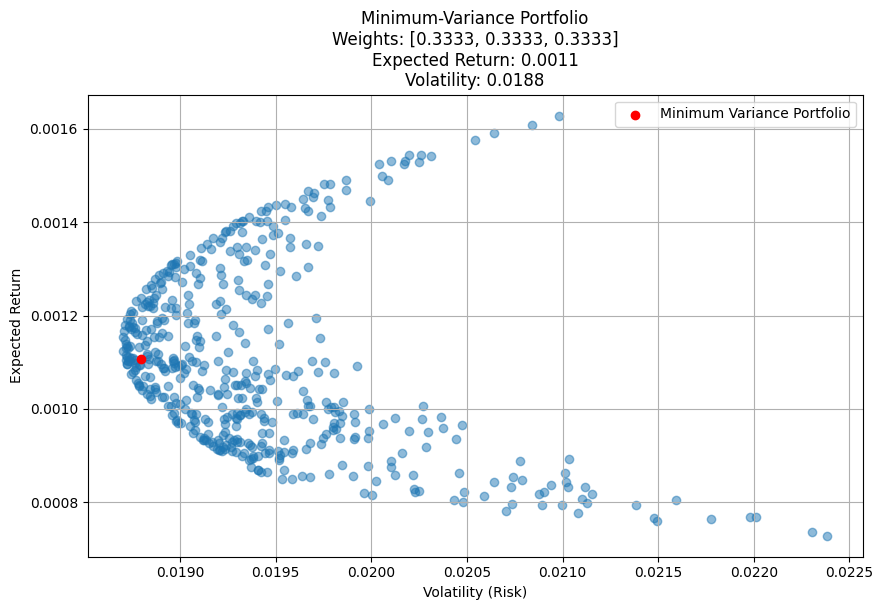

In [ ]:
# 다시 위 코드에서 title에 출력될 변수들을 소수점 네자리까지만 고려
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tickers = ['AAPL', 'GOOGL', 'AMZN']
df = yf.download(tickers, start='2019-01-01')['Adj Close']
returns = df.pct_change(1).dropna()

# 공분산 행렬 계산
cov_matrix = returns.cov()

# 포트폴리오 종목 비중 초기화: uniform weights로
num_assets = len(returns.columns)
weights = np.ones(num_assets) / num_assets

# 최적화 함수로 최소 분산 포트폴리오 계산
from scipy.optimize import minimize

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # 비중 합계는 1
bounds = tuple((0, 1) for _ in range(num_assets))  # 각 비중은 0과 1 사이

result = minimize(portfolio_variance, weights, args=(cov_matrix,),
                  method='SLSQP', constraints=constraints, bounds=bounds)

optimal_weights = result.x
min_variance = result.fun

# 최소 분산 포트폴리오 수익률 계산
expected_returns = returns.mean()
min_portfolio_return = np.dot(expected_returns, optimal_weights)

# 포트폴리오 시뮬레이션
n_simulations = 500
returns_simulated = np.zeros(n_simulations)
volatility_simulated = np.zeros(n_simulations)

for i in range(n_simulations):
    weights_simulated = np.random.dirichlet(np.ones(num_assets), size=1).flatten()
    returns_simulated[i] = np.dot(expected_returns, weights_simulated)
    volatility_simulated[i] = np.sqrt(portfolio_variance(weights_simulated, cov_matrix))

# 최소 분산 포트폴리오 그래프
plt.figure(figsize=(10, 6))
plt.scatter(volatility_simulated, returns_simulated, marker='o', alpha=0.5)
plt.scatter(np.sqrt(min_variance), min_portfolio_return, marker='o', color='red', label='Minimum Variance Portfolio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')

# 수정된 부분: optimal_weights, min_portfolio_return, np.sqrt(min_variance) 소수점 아래 4자리 출력
optimal_weights_rounded = [round(weight, 4) for weight in optimal_weights]
min_portfolio_return_rounded = round(min_portfolio_return, 4)
min_variance_rounded = round(np.sqrt(min_variance), 4)
title = f"Minimum-Variance Portfolio\nWeights: {optimal_weights_rounded}\nExpected Return: {min_portfolio_return_rounded}\nVolatility: {min_variance_rounded}"
plt.title(title)
plt.legend()
plt.grid(True)
plt.show()

위 코드를 tickers, start_date, end_date와 n_simulations를 input으로 받고

위 Minimum Variance portfolio와 임의의 weights들에 대한 포트폴리오들을 plot시킨 그래프를 전부 출력시키는 함수로 만들자:

[*********************100%***********************]  5 of 5 completed


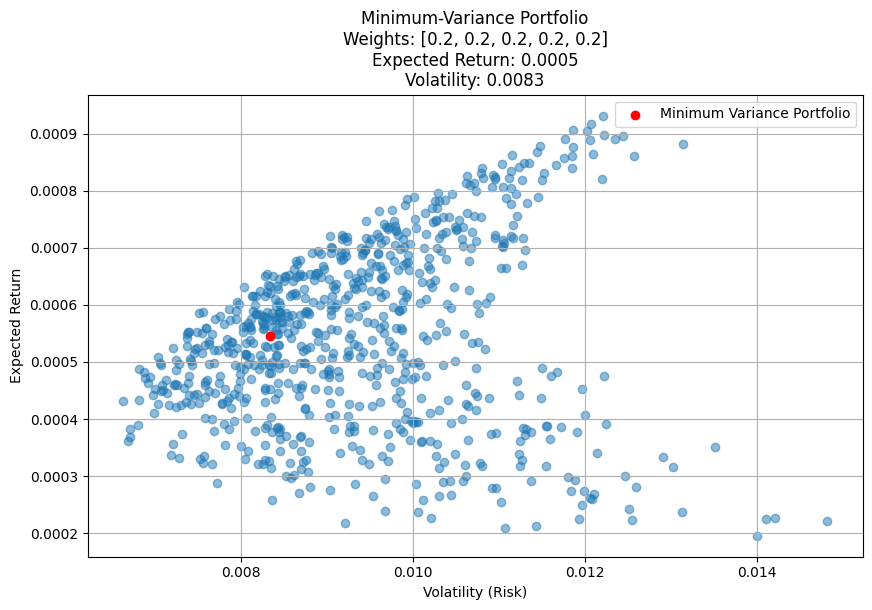

In [ ]:
# Minimum Variance portfolio와 임의의 weights들에 대한 포트폴리오들을 plot시킨 그래프를 전부 출력시키는 함수
def plot_MVP(tickers, start_date, end_date, n_simulations):
    df = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    returns = df.pct_change(1).dropna()

    # 공분산 행렬 계산
    cov_matrix = returns.cov()

    # 포트폴리오 종목 비중 초기화: uniform weights로
    num_assets = len(returns.columns)
    weights = np.ones(num_assets) / num_assets

    # 최적화 함수로 최소 분산 포트폴리오 계산
    from scipy.optimize import minimize

    def portfolio_variance(weights, cov_matrix):
        return np.dot(weights.T, np.dot(cov_matrix, weights))

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # 비중 합계는 1
    bounds = tuple((0, 1) for _ in range(num_assets))  # 각 비중은 0과 1 사이

    result = minimize(portfolio_variance, weights, args=(cov_matrix,),
                    method='SLSQP', constraints=constraints, bounds=bounds)

    optimal_weights = result.x
    min_variance = result.fun

    # 최소 분산 포트폴리오 수익률 계산
    expected_returns = returns.mean()
    min_portfolio_return = np.dot(expected_returns, optimal_weights)

    # 포트폴리오 시뮬레이션
    # n_points = 500
    returns_simulated = np.zeros(n_simulations)
    volatility_simulated = np.zeros(n_simulations)

    for i in range(n_simulations):
        weights_simulated = np.random.dirichlet(np.ones(num_assets), size=1).flatten()
        returns_simulated[i] = np.dot(expected_returns, weights_simulated)
        volatility_simulated[i] = np.sqrt(portfolio_variance(weights_simulated, cov_matrix))

    # 최소 분산 포트폴리오 그래프
    plt.figure(figsize=(10, 6))
    plt.scatter(volatility_simulated, returns_simulated, marker='o', alpha=0.5)
    plt.scatter(np.sqrt(min_variance), min_portfolio_return, marker='o', color='red', label='Minimum Variance Portfolio')
    plt.xlabel('Volatility (Risk)')
    plt.ylabel('Expected Return')

    # 수정된 부분: optimal_weights, min_portfolio_return, np.sqrt(min_variance) 소수점 아래 4자리 출력
    optimal_weights_rounded = [round(weight, 4) for weight in optimal_weights]
    min_portfolio_return_rounded = round(min_portfolio_return, 4)
    min_variance_rounded = round(np.sqrt(min_variance), 4)
    title = f"Minimum-Variance Portfolio\nWeights: {optimal_weights_rounded}\nExpected Return: {min_portfolio_return_rounded}\nVolatility: {min_variance_rounded}"
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

tickers = ['GLD', 'SLV', 'AAPL', 'MSFT', 'KO']
start_date = '2010-01-01'
end_date = '2020-02-01'
n_simulations = 750
plot_MVP(tickers, start_date, end_date, n_simulations)

## 3. Min-Var portfolio w/ colorbar describing Sharpe ratio
같은 방법으로 아래와 같이 구현할 수도 있다 (물론 본질적으로 바탕이되는 수식은 위와 똑같다.)

그리고 여기서는 plot할 때,

plt.scatter(vol_portf, ret_portf, `c=ret_portf/vol_portf`, marker='o')<br>
plt.`colorbar`(label='Sharpe ratio')

파트에서 colorbar로 샤프 비율을 시각적으로 나타냈다.

[참고한 블로그](https://hive.blog/dclick/@thrufore/day2-with-python-1539446432982)<br>
[같은 블로그인듯](https://steemit.com/dclick/@thrufore/day2-with-python-1539446432982):

[*********************100%***********************]  3 of 3 completed


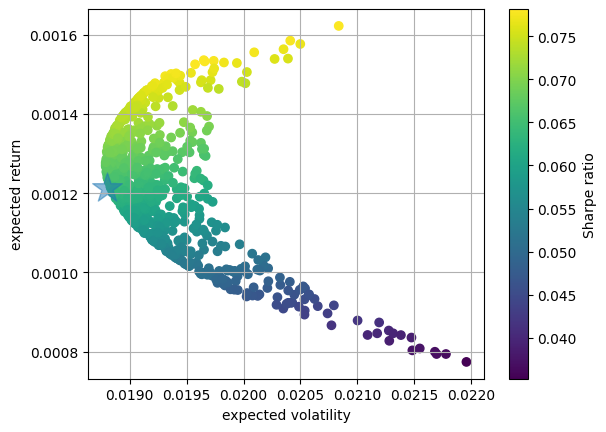

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# MVP와 함께 colorbar로 Sharpe ratio도 표시하는 함수
def plot_MVP_Sr(tickers, start_date, end_date, n_simulations):
    df = yf.download(tickers, start='2019-01-01')['Adj Close']
    returns = df.pct_change(1).dropna()

    ret_portf, vol_portf = [], []  # 포트폴리오의 returns & volatility
    num_assets = len(tickers)
    ret_mean = returns.mean()
    cov_mtx = returns.cov()

    for _ in range(n_simulations):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights) # normalize so that sum of weights to be 1
        ret_portf.append(np.sum(ret_mean * weights))
        vol_portf.append(np.sqrt(np.dot(np.dot(weights.T, cov_mtx), weights)))

    ret_portf = np.array(ret_portf)
    vol_portf = np.array(vol_portf)

    # minimize variance
    import scipy.optimize as sco

    def obj(weights):
        return np.sqrt(np.dot(np.dot(weights.T, cov_mtx), weights))

    w = np.ones(num_assets) / num_assets
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bnds = tuple((0, 1) for _ in range(num_assets))
    opt = sco.minimize(obj, w, method='SLSQP', bounds=bnds, constraints=cons)

    w_opt = opt['x']
    ret_opt = np.sum(ret_portf.mean() * opt['x'])
    vol_opt = np.sqrt(np.dot(np.dot(opt['x'].T, cov_mtx), opt['x']))

    plt.scatter(vol_portf, ret_portf, c=ret_portf/vol_portf, marker='o')
    plt.grid(True)
    plt.xlabel('expected volatility')
    plt.ylabel('expected return')
    plt.colorbar(label='Sharpe ratio')
    plt.scatter(vol_opt, ret_opt, marker='*', s=500, alpha=0.5)  # s는 마커의 크기를 설정
    plt.show()

tickers = ['AAPL', 'MSFT', 'AMZN']
start_date = '2010-01-01'
end_date = '2020-02-01'
n_simulations = 750
plot_MVP_Sr(tickers, start_date, end_date, n_simulations)

[*********************100%***********************]  3 of 3 completed


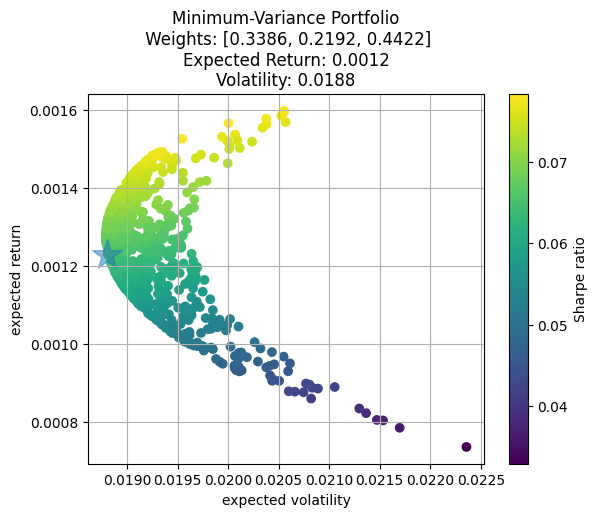

In [ ]:
# 위 코드에 title에 Min-Variance Weights/expected returns/expected volatility를 표기해주는 코드만 추가
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# MVP와 함께 colorbar로 Sharpe ratio도 표시하는 함수
def plot_MVP_Sr(tickers, start_date, end_date, n_simulations):
    df = yf.download(tickers, start='2019-01-01')['Adj Close']
    returns = df.pct_change(1).dropna()

    ret_portf, vol_portf = [], []  # 포트폴리오의 returns & volatility
    num_assets = len(tickers)
    ret_mean = returns.mean()
    cov_mtx = returns.cov()

    for _ in range(n_simulations):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights) # normalize so that sum of weights to be 1
        ret_portf.append(np.sum(ret_mean * weights))
        vol_portf.append(np.sqrt(np.dot(np.dot(weights.T, cov_mtx), weights)))

    ret_portf = np.array(ret_portf)
    vol_portf = np.array(vol_portf)

    # minimize variance
    import scipy.optimize as sco

    def obj(weights):
        return np.sqrt(np.dot(np.dot(weights.T, cov_mtx), weights))

    w = np.ones(num_assets) / num_assets
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bnds = tuple((0, 1) for _ in range(num_assets))
    opt = sco.minimize(obj, w, method='SLSQP', bounds=bnds, constraints=cons)

    w_opt = opt['x']
    ret_opt = np.sum(ret_portf.mean() * opt['x'])
    vol_opt = np.sqrt(np.dot(np.dot(opt['x'].T, cov_mtx), opt['x']))

    plt.scatter(vol_portf, ret_portf, c=ret_portf/vol_portf, marker='o')
    plt.grid(True)
    plt.xlabel('expected volatility')
    plt.ylabel('expected return')

    w_opt_rounded = [round(weight, 4) for weight in w_opt]
    ret_opt_rounded = round(ret_opt, 4)
    vol_opt_rounded = round(vol_opt, 4)
    title = f"Minimum-Variance Portfolio\n Weights: {w_opt_rounded}\nExpected Return: {ret_opt_rounded}\nVolatility: {vol_opt_rounded}"
    plt.title(title)

    plt.colorbar(label='Sharpe ratio')
    plt.scatter(vol_opt, ret_opt, marker='*', s=500, alpha=0.5)  # s는 마커의 크기를 설정
    plt.show()

tickers = ['AAPL', 'MSFT', 'AMZN']
start_date = '2010-01-01'
end_date = '2020-02-01'
n_simulations = 750
plot_MVP_Sr(tickers, start_date, end_date, n_simulations)

## 4. PyPortfolioOpt 패키지와 pulp를 이용하는 방법
PyPortfolioOpt 패키지는 [링크](https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html)에서 정보를 확인할 수 있으니 한 번 읽어보자.

[blog](https://skyeong.net/271)에서 참조:


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import datetime

In [ ]:
tickers = ['AAPL', 'MSFT', 'AMZN', 'NFLX', 'GOOGL']
num_assets = len(tickers)
weights = np.ones(num_assets) / num_assets
weights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [ ]:
start_date = '2013-01-01'
today = datetime.today().strftime('%Y-%m-%d')

df = pd.DataFrame()
for stock in tickers:
    df[stock] = yf.download(stock, start=start_date, end=today)['Adj Close']
df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AAPL,MSFT,AMZN,NFLX,GOOGL
Date,,,,,
2013-01-02,16.813858,22.668232,12.8655,13.144286,18.099348
2013-01-03,16.601633,22.364571,12.9240,13.798571,18.109859
2013-01-04,16.139200,21.945997,12.9575,13.711429,18.467718
2013-01-07,16.044260,21.904961,13.4230,14.171429,18.387136
2013-01-08,16.087442,21.790060,13.3190,13.880000,18.350851


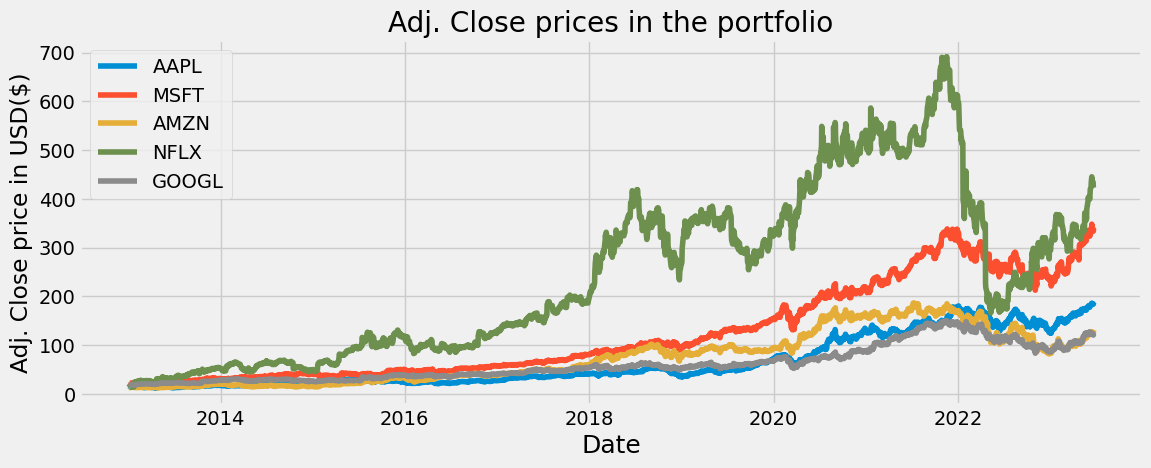

In [ ]:
plt.figure(figsize=(12.2,4.5))
for c in df.columns.values:
    plt.plot(df[c], label=c)
plt.title('Adj. Close prices in the portfolio')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adj. Close price in USD($)')
plt.legend()
plt.show()

In [ ]:
returns = df.pct_change().dropna()
returns

,AAPL,MSFT,AMZN,NFLX,GOOGL
Date,,,,,
2013-01-03,-0.012622,-0.013396,0.004547,0.049777,0.000581
2013-01-04,-0.027855,-0.018716,0.002592,-0.006315,0.019760
2013-01-07,-0.005883,-0.001870,0.035925,0.033549,-0.004363
2013-01-08,0.002691,-0.005245,-0.007748,-0.020565,-0.001973
2013-01-09,-0.015629,0.005650,-0.000113,-0.012865,0.006573
...,...,...,...,...,...
2023-06-15,0.011199,0.031897,0.005458,0.010003,0.011482
2023-06-16,-0.005860,-0.016576,-0.012745,-0.029892,-0.012471
2023-06-20,0.000487,-0.012503,0.002311,0.006343,-0.003481


In [ ]:
cov_matrix_annual = returns.cov() * 252
cov_matrix_annual

,AAPL,MSFT,AMZN,NFLX,GOOGL
AAPL,0.082820,0.048710,0.047684,0.043562,0.044989
MSFT,0.048710,0.073520,0.053180,0.050645,0.051474
AMZN,0.047684,0.053180,0.107447,0.074012,0.056494
NFLX,0.043562,0.050645,0.074012,0.224347,0.055392
GOOGL,0.044989,0.051474,0.056494,0.055392,0.075058


In [ ]:
var_portf = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
var_portf

0.06461886495407164

In [ ]:
vol_portf = np.sqrt(var_portf)
vol_portf

0.2542024094183052

In [ ]:
SimpleAnnualReturn_portf = np.sum(returns.mean() * weights) * 250
print('Expected annual return:', round(SimpleAnnualReturn_portf, 4) * 100, '%')
print('Annual volatility/risk/std. dev.:', round(vol_portf, 4) * 100, '%')
print('Annual variance:', round(var_portf, 4) * 100, '%')

Expected annual return: 29.9 %
Annual volatility/risk/std. dev.: 25.419999999999998 %
Annual variance: 6.460000000000001 %


위 예상 수익률과 리스크를 상회하는 최적 포트폴리오를 찾아본다

(여기서 optimal은 Sharpe ratio를 최대화하는 포트폴리오를 구축한다는 의미이다):

In [ ]:
pip install PyPortfolioOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.4 MB/s eta 0:00:00


In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# expected annual returns & sample covariaance matrix
mu = expected_returns.mean_historical_return(df)
C = risk_models.sample_cov(df)

ef = EfficientFrontier(mu, C)
weights = ef.max_sharpe()  # get raw weights maximizing Sharpe ratio
weights_cleaned = ef.clean_weights()  # 계산된 비중(weights)을 정리하여 불필요한 작은 값이나 오차를 제거
print(weights_cleaned)
ef.portfolio_performance(verbose=True)  # 최적화된 포트폴리오의 성과를 출력/verbose='True'로 설정하면 자세하게 출력/출력 결과에는 포트폴리오의 예상 연간 수익률, 예상 연간 변동성, 샤프 지수가 포함된다.

OrderedDict([('AAPL', 0.21527), ('MSFT', 0.57308), ('AMZN', 0.0), ('NFLX', 0.21165), ('GOOGL', 0.0)])
Expected annual return: 30.8%
Annual volatility: 25.8%
Sharpe Ratio: 1.12


(0.3084170323253436, 0.2575017079093941, 1.1200587159865656)

In [ ]:
weights

OrderedDict([('AAPL', 0.21527),
             ('MSFT', 0.57308),
             ('AMZN', 0.0),
             ('NFLX', 0.21165),
             ('GOOGL', 0.0)])

In [ ]:
weights_cleaned

OrderedDict([('AAPL', 0.21527),
             ('MSFT', 0.57308),
             ('AMZN', 0.0),
             ('NFLX', 0.21165),
             ('GOOGL', 0.0)])


ef.max_sharpe(): 샤프 지수를 최대화하는 최적의 비중(weights)을 계산합니다. 최적화는 주어진 평균 연간 수익률(mu)와 공분산 행렬(C)을 기반으로 이루어집니다.

ef.clean_weights(): 계산된 비중(weights)을 정리하여 불필요한 작은 값이나 오차를 제거합니다.

ef.portfolio_performance(verbose=True): 최적화된 포트폴리오의 성과를 출력합니다. 이때, verbose 매개변수를 True로 설정하면 자세한 결과를 확인할 수 있습니다. 출력 결과에는 포트폴리오의 예상 연간 수익률, 예상 연간 변동성, 샤프 지수가 포함됩니다.

Sharpe ratio-maximizing 포트폴리오에서 Sharpe ratio = 1.12 로 나타났다.

In [ ]:
pip install pulp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 31.6 MB/s eta 0:00:00


In [ ]:
'''
각 자산의 개별 할당량을 (weights_cleaned에 따라) 계산
이를 위해 pip install pulp 필요
'''
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)
weights = weights_cleaned

# 위 포트폴리오에 15000 USD를 투자하는 경우
'''
DiscreteAllocation(): 이 클래스는 최적화된 비중(weights)과 최신 가격 정보(latest_prices)를 사용하여 개별 자산에 할당할 수 있는 최대 수량을 계산하는 기능을 제공
da.lp_portfolio(): linear programming을 사용하여 최대 수량 할당을 계산
'''
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=15000)
allocation, leftover = da.lp_portfolio()

print("Discrete allocation: ", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation:  {'MSFT': 27, 'AMZN': 7, 'NFLX': 9, 'GOOGL': 8}
Funds remaining: $129.26


# #5.pyptopt 와 DiscreteAllocation로 min-var/max-Sharpe ratio 포트폴리오의 자산 배분 비율과 그 값을 출력하고 barh()로 plot

[tistory blog](https://hotorch.tistory.com/64) 에서 참조:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from tqdm import tqdm

# O: 리얼티인컴 MAIN: 메인 스트리트 캐피털
tickers = ['MSFT','NVDA','O','AAPL','TSLA','JPM','SBUX','MAIN','AMZN']
prices = yf.download(tickers, start='2010-01-01',end='2021-08-22')['Adj Close'].dropna(how='all')
# prices = yf.download(tickers, start='2013-01-01',end='2021-08-22')['Adj Close'].dropna(how='all')
prices.head()

[*********************100%***********************]  10 of 10 completed


,AAPL,AMZN,JPM,MAIN,META,MSFT,NVDA,O,SBUX,TSLA
Date,,,,,,,,,,
2010-01-04,6.496295,6.6950,30.279610,5.618419,NaN,23.572371,4.241151,13.624306,9.164431,NaN
2010-01-05,6.507526,6.7345,30.866119,5.486138,NaN,23.579987,4.303082,13.853992,9.379132,NaN
2010-01-06,6.404015,6.6125,31.035709,5.440887,NaN,23.435278,4.330607,13.843544,9.311542,NaN
2010-01-07,6.392176,6.5000,31.650490,5.597534,NaN,23.191555,4.245738,14.135870,9.287686,NaN
2010-01-08,6.434674,6.6760,31.572773,5.545318,NaN,23.351482,4.254912,14.329013,9.255878,NaN


In [ ]:
df = prices

In [ ]:
daily_ret = df.pct_change().dropna()
annual_ret = daily_ret.mean() * 250
daily_cov = daily_ret.cov()
annual_cov = daily_cov * 250

# returns/volatility/weights/Sharpe ratios for randomly weighted portfolio
port_ret, port_vol, port_wgt, port_sr = [], [], [], []
num_assets = len(tickers)

# simulate random portfolios & pile the lists
for _ in tqdm(range(300000)):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)

    returns = np.dot(weights, annual_ret)
    volatility = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights)))

    port_ret.append(returns)
    port_vol.append(volatility)
    port_wgt.append(weights)
    port_sr.append(returns/volatility)

100%|██████████| 300000/300000 [00:14<00:00, 20389.90it/s]


In [ ]:
# turn the random portfolios (i.e., investment opportunity set) into DataFrame
rand_port = {'Returns': port_ret, 'Volatility': port_vol, 'Sharpe ratio': port_sr}
for i, s in enumerate(tqdm(tickers)):
    rand_port[s] = [weight[i] for weight in port_wgt]

df = pd.DataFrame(rand_port)
df = df[['Returns', 'Volatility', 'Sharpe ratio'] + [s for s in tickers]]

df

100%|██████████| 10/10 [00:00<00:00, 34.03it/s]


,Returns,Volatility,Sharpe ratio,MSFT,NVDA,O,AAPL,META,TSLA,JPM,SBUX,MAIN,AMZN
0,0.263829,0.212999,1.238640,0.003246,0.042347,0.153285,0.003184,0.305598,0.063897,0.003330,0.315256,0.047960,0.061896
1,0.373455,0.235585,1.585226,0.056091,0.050734,0.141753,0.153399,0.047898,0.065110,0.187516,0.008159,0.111505,0.177836
2,0.298201,0.208635,1.429298,0.111245,0.126128,0.146897,0.167636,0.007461,0.026947,0.012795,0.123145,0.131929,0.145817
3,0.283668,0.200987,1.411375,0.101840,0.155912,0.022856,0.051594,0.139554,0.154413,0.059491,0.151350,0.142211,0.020778
4,0.347623,0.223970,1.552095,0.078801,0.152576,0.042737,0.159518,0.156359,0.053799,0.138758,0.045646,0.057404,0.114403
...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0.313501,0.210372,1.490226,0.143504,0.008471,0.097352,0.121655,0.079134,0.147985,0.139382,0.042678,0.157792,0.062048
299996,0.309936,0.207172,1.496034,0.153507,0.150196,0.043217,0.092823,0.056772,0.050802,0.054435,0.134772,0.149429,0.114046
299997,0.298468,0.204936,1.456399,0.115189,0.077709,0.007403,0.128535,0.136692,0.148888,0.082393,0.147300,0.094390,0.061500
299998,0.339633,0.228112,1.488890,0.129304,0.093425,0.064205,0.023730,0.231148,0.241456,0.042092,0.038331,0.024497,0.111813


1. Min-Variance portfolio (최소-분산 포트폴리오)와
2. Max-Sharpe ratio portfolio (최대-샤프지수 포트폴리오)

를 골라보고 `volatility-expected returns 그래프`에 plot해보자.

In [ ]:
min_vol = df['Volatility'].min()
max_sr = df['Sharpe ratio'].max()

# minimum volatility(variance) 포트폴리오 & maximum Sharpe ratio 포트폴리오
port_min_vol = df.loc[df['Volatility'] == min_vol]
port_max_sr = df.loc[df['Sharpe ratio'] == max_sr]

print(port_min_vol)
print(port_max_sr)

         Returns  Volatility  Sharpe ratio      MSFT      NVDA         O  \
229387  0.236829    0.188371      1.257252  0.098624  0.157579  0.117403   

            AAPL      META      TSLA       JPM      SBUX      MAIN      AMZN  
229387  0.126705  0.016491  0.066758  0.014702  0.197313  0.201321  0.003105  
         Returns  Volatility  Sharpe ratio      MSFT      NVDA         O  \
261756  0.426165    0.258145      1.650875  0.037684  0.152672  0.126706   

            AAPL      META      TSLA       JPM      SBUX      MAIN      AMZN  
261756  0.022158  0.034637  0.095196  0.274512  0.010979  0.051604  0.193853  


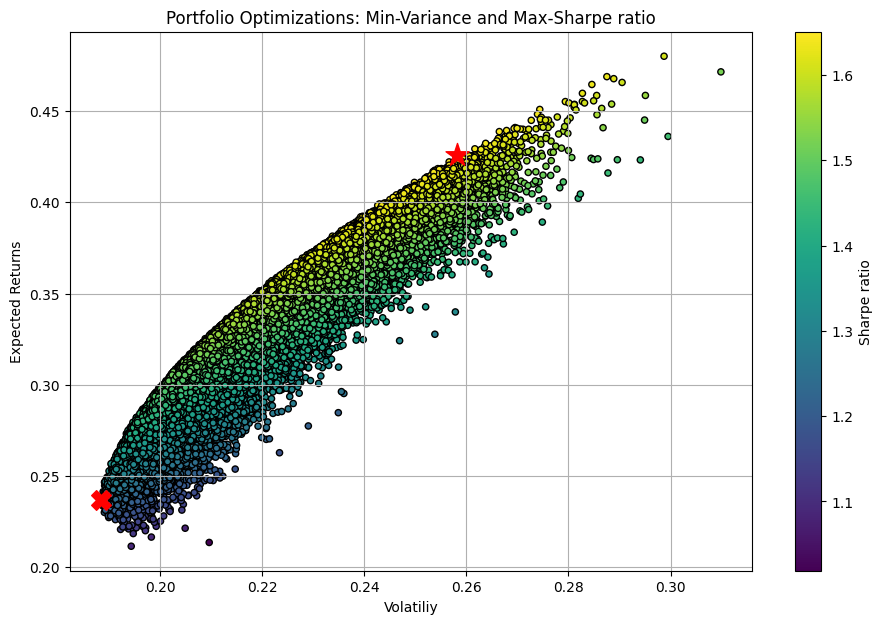

In [ ]:
# random portfolios/min-var/max-sharpe ratio portfolios를 각각 plot
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe ratio', cmap='viridis',
                edgecolors='k', figsize=(11,7), grid=True)
plt.scatter(x=port_max_sr['Volatility'], y=port_max_sr['Returns'], c='r',
            marker='*', s=300)
plt.scatter(x=port_min_vol['Volatility'], y=port_min_vol['Returns'], c='r',
            marker='X', s=200)
plt.title('Portfolio Optimizations: Min-Variance and Max-Sharpe ratio')
plt.xlabel('Volatiliy')
plt.ylabel('Expected Returns')
plt.show()

In [ ]:
# Max-Sharpe ratio 포트폴리오의 각 자산 비중: dict. 형
wgt_max_sr_dict = dict(zip(list(port_max_sr[tickers].columns),
                             port_max_sr[tickers].values.flatten().tolist()))
wgt_max_sr_dict

{'MSFT': 0.03768361659653936,
 'NVDA': 0.1526723426616448,
 'O': 0.12670580858197833,
 'AAPL': 0.02215762986677612,
 'META': 0.03463700534174765,
 'TSLA': 0.09519606862206832,
 'JPM': 0.274511513333515,
 'SBUX': 0.01097872526825703,
 'MAIN': 0.05160408827242903,
 'AMZN': 0.19385320145504445}

<Axes: >

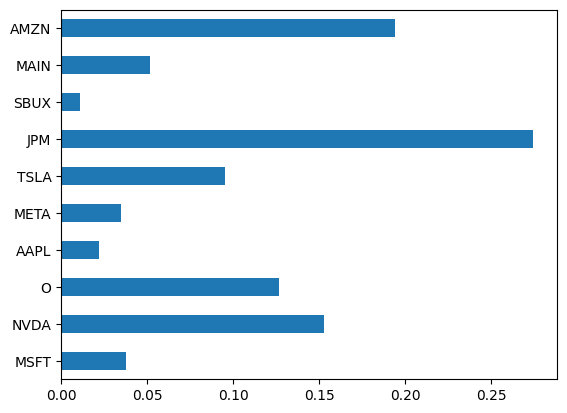

In [ ]:
# barhplot으로 시각화
from collections import OrderedDict
wgt_max_sr = OrderedDict(wgt_max_sr_dict)
pd.Series(wgt_max_sr).plot.barh()

마찬가지로 min-variance portfolio에 대한 자산 비중을 구하고

시각화하면 다음과 같다:

In [ ]:
wgt_min_var_dict = dict(zip(list(port_min_vol[tickers].columns),
                                 port_min_vol[tickers].values.flatten().tolist()))
wgt_min_var_dict

{'MSFT': 0.09862371968879773,
 'NVDA': 0.15757889003423686,
 'O': 0.11740287336330063,
 'AAPL': 0.1267047757245956,
 'META': 0.016490800242828278,
 'TSLA': 0.06675807582346696,
 'JPM': 0.01470191976701896,
 'SBUX': 0.19731258163536725,
 'MAIN': 0.20132140890139563,
 'AMZN': 0.003104954818992141}

<Axes: >

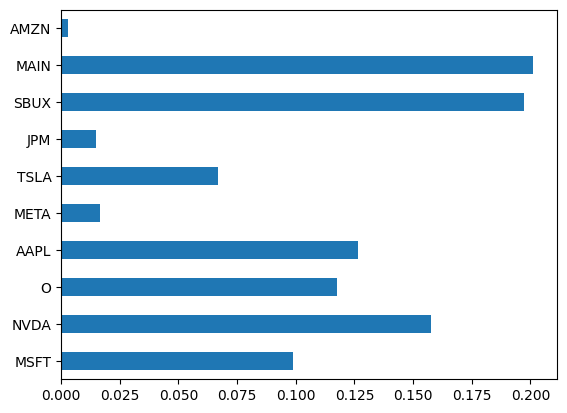

In [ ]:
wgt_min_var = OrderedDict(wgt_min_var_dict)
pd.Series(wgt_min_var).plot.barh()

위와 마찬가지로 pypfopt의 DiscreteAllocation을 사용하여

마지막 종가 기준으로 10000 USD를 위 포트폴리오에 투자할 때, 각 자산 배분을 어떻게 하는지 보여준다:

In [ ]:
pip install PyPortfolioOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 5.7 MB/s eta 0:00:00


In [ ]:
from pypfopt import DiscreteAllocation

latest_prices = prices.iloc[-1] # 마지막 종가 기준
da = DiscreteAllocation(wgt_max_sr, latest_prices, total_portfolio_value=10000)
alloc, leftover = da.lp_portfolio()
print(f"Discrete allocation performed with ${leftover:.2f}leftover")
alloc

Discrete allocation performed with $104.79leftover


/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


{'NVDA': 10,
 'O': 9,
 'AAPL': 8,
 'META': 1,
 'TSLA': 3,
 'JPM': 13,
 'SBUX': 2,
 'MAIN': 5,
 'AMZN': 9}

물론 min_vol 포트폴리오에 투자할 때의 자산 배분은 다음과 같다:

In [ ]:

latest_prices = prices.iloc[-1] # 마지막 종가 기준
da = DiscreteAllocation(wgt_min_var, latest_prices, total_portfolio_value=10000)
alloc, leftover = da.lp_portfolio()
print(f"Discrete allocation performed with ${leftover:.2f}leftover")
alloc

Discrete allocation performed with $134.60leftover


{'MSFT': 7,
 'NVDA': 10,
 'O': 8,
 'AAPL': 35,
 'TSLA': 2,
 'JPM': 1,
 'SBUX': 31,
 'MAIN': 18}

## #6 `pypfopt`를 통해 efficient frontier/min-variance & max-Sharpe ratio portfolio + CML 구축, plot 및 backtest

`pypfopt` 를 사용해서 efficient frontier/min-variance portfolio/max-Sharpe ratio portfolio를 구축하고 CML과 함께 plot한 후에 시장 지수와 함께 plot해서 backtest한다:

1. reference: [Mean-Variance Portfolio Optimization using Python](https://lumos-datascience.medium.com/mean-variance-portfolio-optimization-using-python-8485fccb9f8b)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import yfinance as yf

tickers = ['AAPL', 'MSFT', 'AMZN', 'NFLX', 'GOOGL'] # 'TSLA': 변동성이 너무 커서 cumrets 그래프를 그리면 다른 종목들의 누적수익률을 제대로 볼 수 없어서 제외
df = yf.download(tickers, start='2010-01-01')['Adj Close']
df

[*********************100%***********************]  5 of 5 completed


,AAPL,AMZN,GOOGL,MSFT,NFLX
Date,,,,,
2010-01-04,6.496293,6.695000,15.684434,23.572363,7.640000
2010-01-05,6.507526,6.734500,15.615365,23.579985,7.358571
2010-01-06,6.404015,6.612500,15.221722,23.435274,7.617143
2010-01-07,6.392176,6.500000,14.867367,23.191557,7.485714
2010-01-08,6.434674,6.676000,15.065566,23.351494,7.614286
...,...,...,...,...,...
2023-06-16,184.919998,125.489998,123.529999,342.329987,431.959991
2023-06-20,185.009995,125.779999,123.099998,338.049988,434.700012
2023-06-21,183.960007,124.830002,120.550003,333.559998,424.450012


In [2]:
rets = df.pct_change(1).dropna()
cumrets = rets.add(1).cumprod().sub(1)*100

In [3]:
# 위 tickers의 누적수익률 plot
fig = px.line(cumrets, x=cumrets.index, y=cumrets.columns, title='Cumulative Returns (2010.01-2023.06)')
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Cumulative Return in %')
fig.show()

In [4]:
tickers_market = ['SPY', 'NDX']  # 'DJIA', 'IXIC'는 NaN 값들이 많아서 일단 제외
df_market = yf.download(tickers_market, start='2010-01-01')['Close'].dropna()
df_market

[*********************100%***********************]  2 of 2 completed


,NDX,SPY
Date,,
2010-01-04,1886.699951,113.330002
2010-01-05,1888.430054,113.629997
2010-01-06,1878.420044,113.709999
2010-01-07,1876.719971,114.190002
2010-01-08,1892.589966,114.570000
...,...,...
2023-06-16,15083.919922,439.459991
2023-06-20,15070.150391,437.179993
2023-06-21,14867.450195,434.940002


In [5]:
# market index들의 누적수익률 plot
rets_index = df_market.pct_change(1).dropna()
cumrets_index = rets_index.add(1).cumprod().sub(1)*100

fig = px.line(cumrets_index, x=cumrets_index.index, y=cumrets_index.columns, title='Cumulative Returns of Market Indices (2010.01-2023.06)')
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Cumulative Return in %')
fig.show()

In [6]:
corr = df[df.columns].corr(method='pearson')
corr

,AAPL,AMZN,GOOGL,MSFT,NFLX
AAPL,1.000000,0.896055,0.961383,0.986834,0.797118
AMZN,0.896055,1.000000,0.937690,0.934311,0.959526
GOOGL,0.961383,0.937690,1.000000,0.978605,0.867892
MSFT,0.986834,0.934311,0.978605,1.000000,0.858235
NFLX,0.797118,0.959526,0.867892,0.858235,1.000000


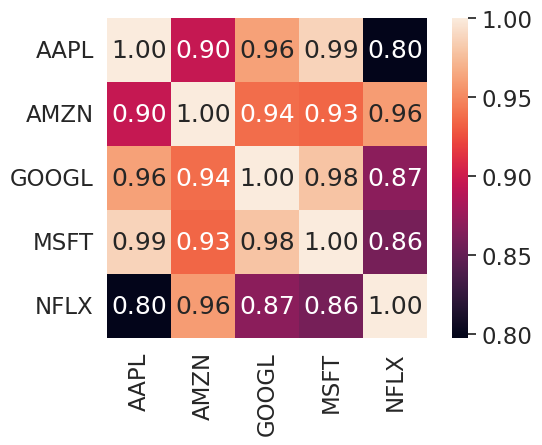

In [7]:
# visualize the Corr matrix using sns.heatmap
sns.set(font_scale=1.5)
heat_map = sns.heatmap(corr.values, cbar=True, annot=True,  # annot=True: heatmap에 상관계수 표기
                       square=True, fmt='.2f',  # fmt를 통해 소수점 2자리까지 상관계수 표기
                    #    annot_kws={'size: 15'},  # heatmap에 출력하는 상관계수의 크기
                       xticklabels=df.columns, yticklabels=df.columns)
plt.tight_layout()
plt.show()

우리의 ticker들중 `AAPL`과 `NFLX`가 correlation coefficient(상관 계수)가 가장 낮음에도 불구하고 무려 0.80이나 된다.

따라서, 그닥 좋지 않은 포트폴리오다.

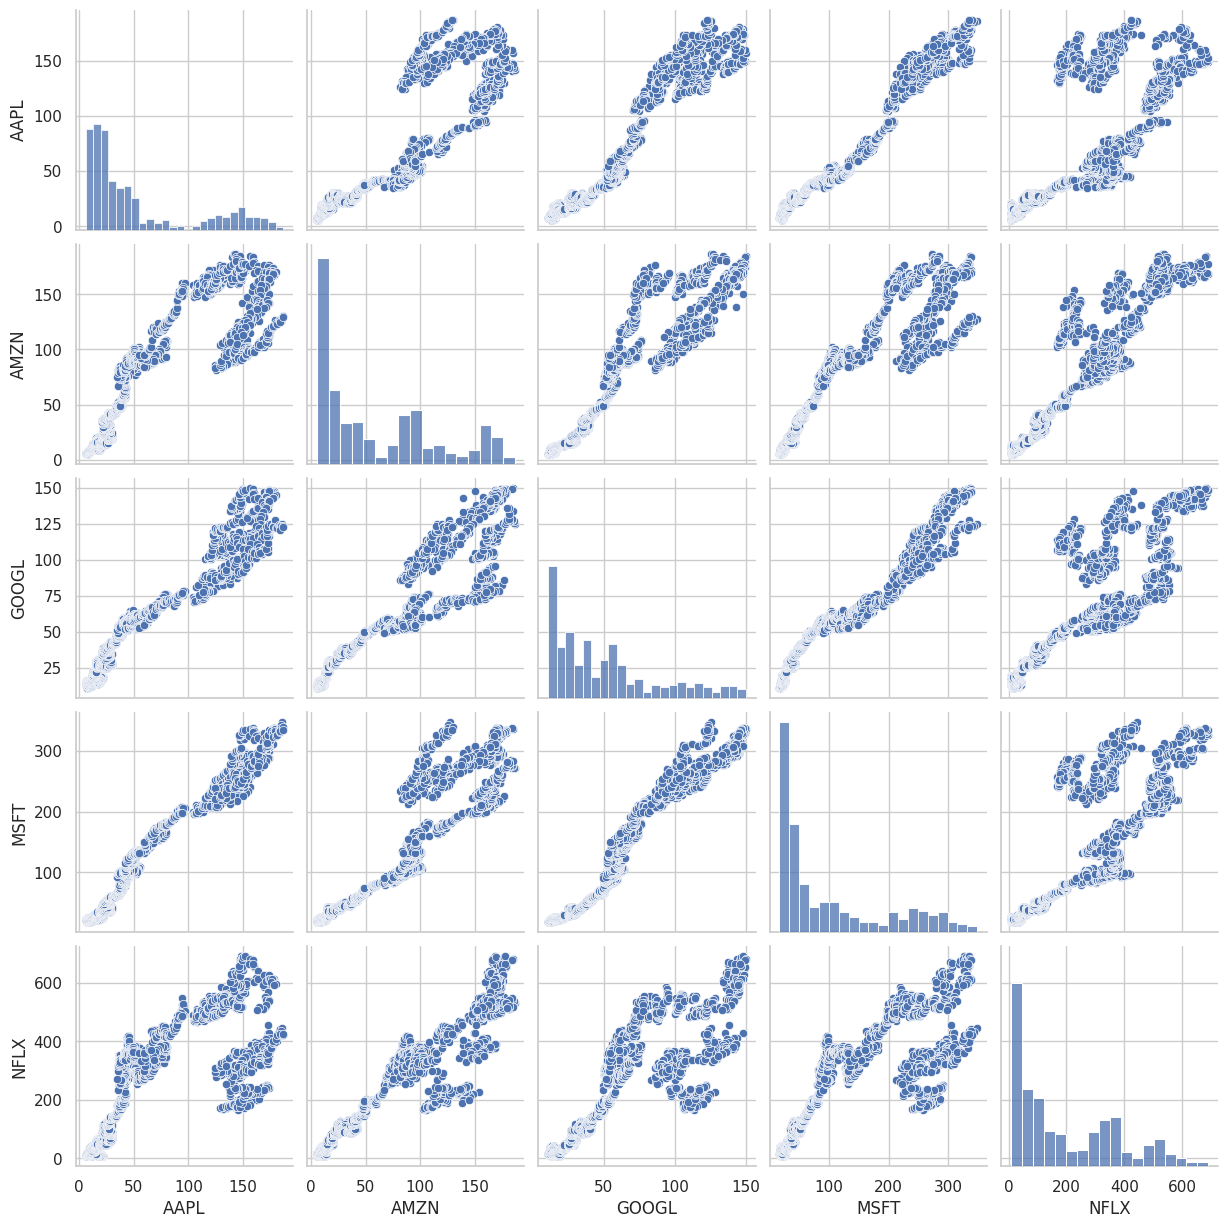

In [8]:
sns.set(style='whitegrid')
sns.pairplot(df)
plt.show()

### Portfolio optimization
1. expected returns and covariance matrix (exponentially weighted)
위와 마찬가지로 `pypfopt` 를 사용

In [9]:
pip install PyPortfolioOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 7.9 MB/s eta 0:00:00


In [10]:
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.risk_models import exp_cov
from pypfopt.expected_returns import ema_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.plotting import plot_weights
from pypfopt.cla import CLA

train = rets[:'2018-10-21']
test = rets['2018-10-21':]

mu = expected_returns.ema_historical_return(train, returns_data=True, span=500)
Sigma = risk_models.exp_cov(train, returns_data=True, span=180)

In [21]:
# 위 코드에서
# 학습 데이터를 사용하여 평균 수익률(mu)과 공분산 행렬(Sigma)을 계산
# ema_historical_return() 함수는 지수 이동 평균을 사용하여 평균 수익률을 계산
# exp_cov() 함수는 주어진 데이터에서 공분산 행렬을 계산
# returns_data=True로 설정하여 데이터가 수익률 데이터임을 알려주고
# span은 이동 평균이나 공분산 계산에 사용되는 기간을 설정하는 매개변수

In [20]:
# 실제 어떤 값이 반환되었는지를 보기위한 예시
# print(mu)
# print(Sigma)

AAPL     0.393652
AMZN     0.500369
GOOGL    0.130852
MSFT     0.370991
NFLX     0.623257
Name: 2018-10-19 00:00:00, dtype: float64
           AAPL      AMZN     GOOGL      MSFT      NFLX
AAPL   0.055053  0.040153  0.034346  0.034555  0.043966
AMZN   0.040153  0.073683  0.045072  0.046939  0.076694
GOOGL  0.034346  0.045072  0.054443  0.040599  0.055462
MSFT   0.034555  0.046939  0.040599  0.051580  0.059467
NFLX   0.043966  0.076694  0.055462  0.059467  0.180588


In [30]:
# ef = EfficientFrontier(mu, Sigma)
# print(ef.efficient_return(0.10))

OrderedDict([('AAPL', 0.373227957535282), ('AMZN', 0.0), ('GOOGL', 0.2803867191581673), ('MSFT', 0.3463853233065508), ('NFLX', 0.0)])


In [31]:
# print(ef.portfolio_performance()[1])

0.20529683248106562


/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning:

The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.



Text(0.5, 1.0, 'Efficient Frontier')

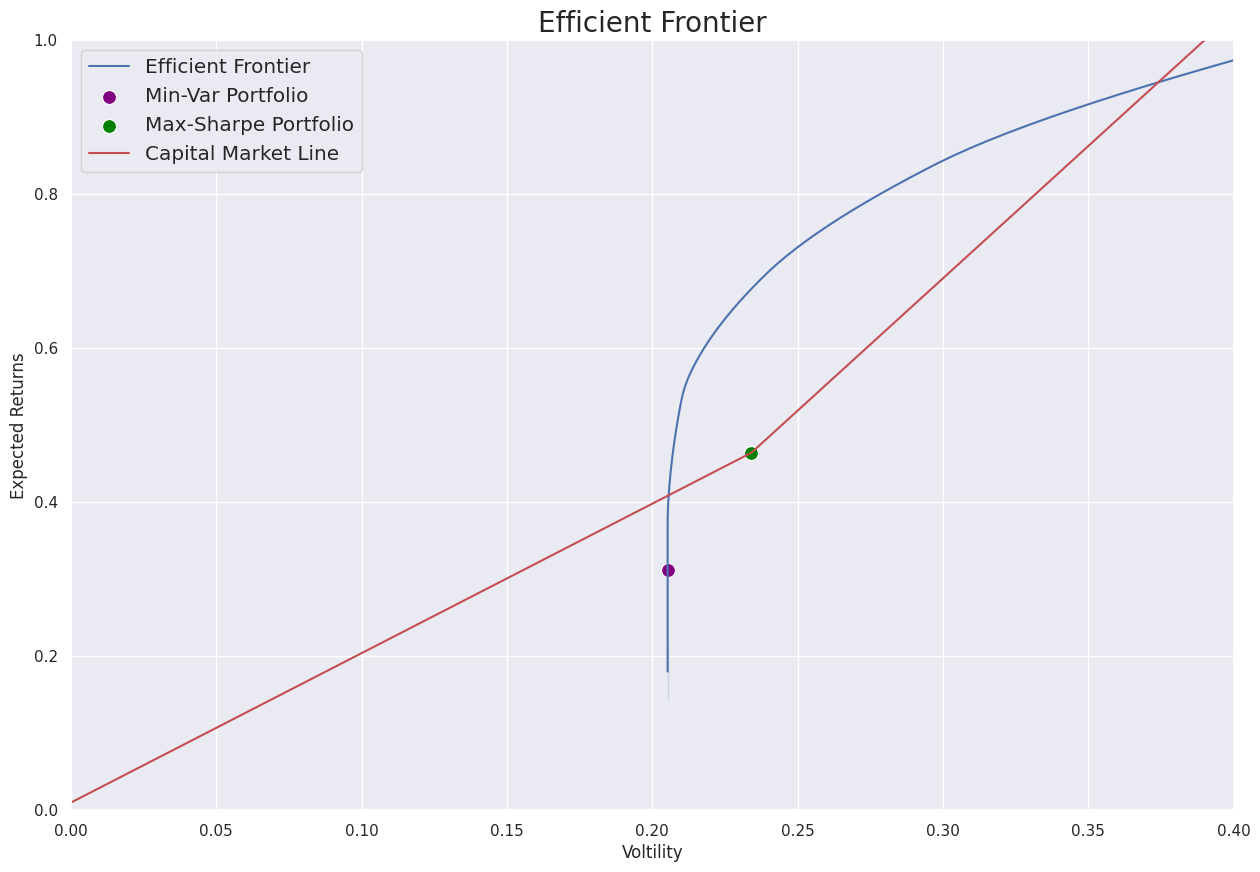

In [32]:
# efficient frontier
ret_ef = np.arange(0, 1, 0.01)
vol_ef = []

for i in np.arange(0, 1, 0.01):
    # ef = EfficientFrontier(mu, Sigma)
    target_return = i * (ef.expected_returns.max() - ef.expected_returns.min()) + ef.expected_returns.min()
    ef = EfficientFrontier(mu, Sigma)  # EfficientFrontier 객체를 새로 생성
    ef.efficient_return(target_return)
    vol_ef.append(ef.portfolio_performance()[1])

ef = EfficientFrontier(mu, Sigma)
ef.min_volatility()
min_vol_ret = ef.portfolio_performance()[0]
min_vol_vol = ef.portfolio_performance()[1]

ef = EfficientFrontier(mu, Sigma)
ef.max_sharpe(risk_free_rate=0.01)
max_sharpe_ret = ef.portfolio_performance()[0]
max_sharpe_vol = ef.portfolio_performance()[1]

sns.set()
fig, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(x=vol_ef, y=ret_ef, ax=ax, label='Efficient Frontier')
sns.scatterplot(x=[min_vol_vol], y=[min_vol_ret], ax=ax, label='Min-Var Portfolio', color='purple', s=100)
sns.scatterplot(x=[max_sharpe_vol], y=[max_sharpe_ret], ax=ax, label='Max-Sharpe Portfolio', color='green', s=100)
sns.lineplot(x=[0, max_sharpe_vol, 1], y=[0.01, max_sharpe_ret, 3.096], label='Capital Market Line', ax=ax, color='r')

ax.set(xlim=[0, 0.4])
ax.set(ylim=[0, 1])
ax.set_xlabel('Voltility')
ax.set_ylabel('Expected Returns')
plt.legend(fontsize='large')
plt.title('Efficient Frontier', fontsize='20')

# ax.figure.savefig('EffFront_big.png', dpi=300)

In [13]:
# efficient frontier - 수정된 코드
ret_ef = np.arange(0, 1, 0.01) # 반환값 범위 설정
vol_ef = []

# 변동성에 따른 효율적인 포트폴리오 계산
for i in np.arange(0, 1, 0.01):
    ef = EfficientFrontier(mu, Sigma)
    target_return = i * (ef.expected_returns.max() - ef.expected_returns.min()) + ef.expected_returns.min()
    ef = EfficientFrontier(mu, Sigma)  # 주어진 평균 수익률(mu)과 공분산(Sigma)으로 EfficientFrontier 객체 생성
    ef.efficient_return(target_return)  # 주어진 반환값(i)에 대한 효율적인 포트폴리오 계산
    vol_ef.append(ef.portfolio_performance()[1])  # 계산된 포트폴리오의 변동성을 vol_ef 리스트에 추가

# 최소 변동성 포트폴리오 계산
ef = EfficientFrontier(mu, Sigma)  # EfficientFrontier 객체 생성
ef.min_volatility()  # 최소 변동성 포트폴리오 계산
min_vol_ret = ef.portfolio_performance()[0]  # 최소 변동성 포트폴리오의 예상 수익률 저장
min_vol_vol = ef.portfolio_performance()[1]  # 최소 변동성 포트폴리오의 변동성 저장

# 최대 샤프 비율 포트폴리오 계산
ef.max_sharpe(risk_free_rate=0.01)  # 최대 샤프 비율 포트폴리오 계산
max_sharpe_ret = ef.portfolio_performance()[0]  # 최대 샤프 비율 포트폴리오의 예상 수익률 저장
max_sharpe_vol = ef.portfolio_performance()[1]  # 최대 샤프 비율 포트폴리오의 변동성 저장

# 그래프 생성과 시각화
sns.set()  # seaborn 설정
fig, ax = plt.subplots(figsize=(15,10))  # 그래프 크기 설정
sns.lineplot(x=vol_ef, y=ret_ef, ax=ax, label='Efficient Frontier')  # 효율적인 포트폴리오 경계 그래프 생성
sns.scatterplot(x=[min_vol_vol], y=[min_vol_ret], ax=ax, label='Min-Var Portfolio', color='purple', s=100)  # 최소 변동성 포트폴리오 그래프 생성
sns.scatterplot(x=[max_sharpe_vol], y=[max_sharpe_ret], ax=ax, label='Max-Sharpe Portfolio', color='green', s=100)  # 최대 샤프 비율 포트폴리오 그래프 생성
sns.lineplot(x=[0, max_sharpe_vol, 1], y=[0.01, max_sharpe_ret, 3.096], label='Capital Market Line', ax=ax, color='r')  # 자본 시장선 그래프 생성

ax.set(xlim=[0, 0.4])
ax.set(ylim=[0, 1])
ax.set_xlabel('Voltility')
ax.set_ylabel('Expected Returns')
plt.legend(fontsize='large')
plt.title('Efficient Frontier', fontsize='20')

# ax.figure.savefig('EffFront_big.png', dpi=300)

InstantiationError: ignored

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning:

The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.



Text(0.5, 1.0, 'Efficient Frontier')

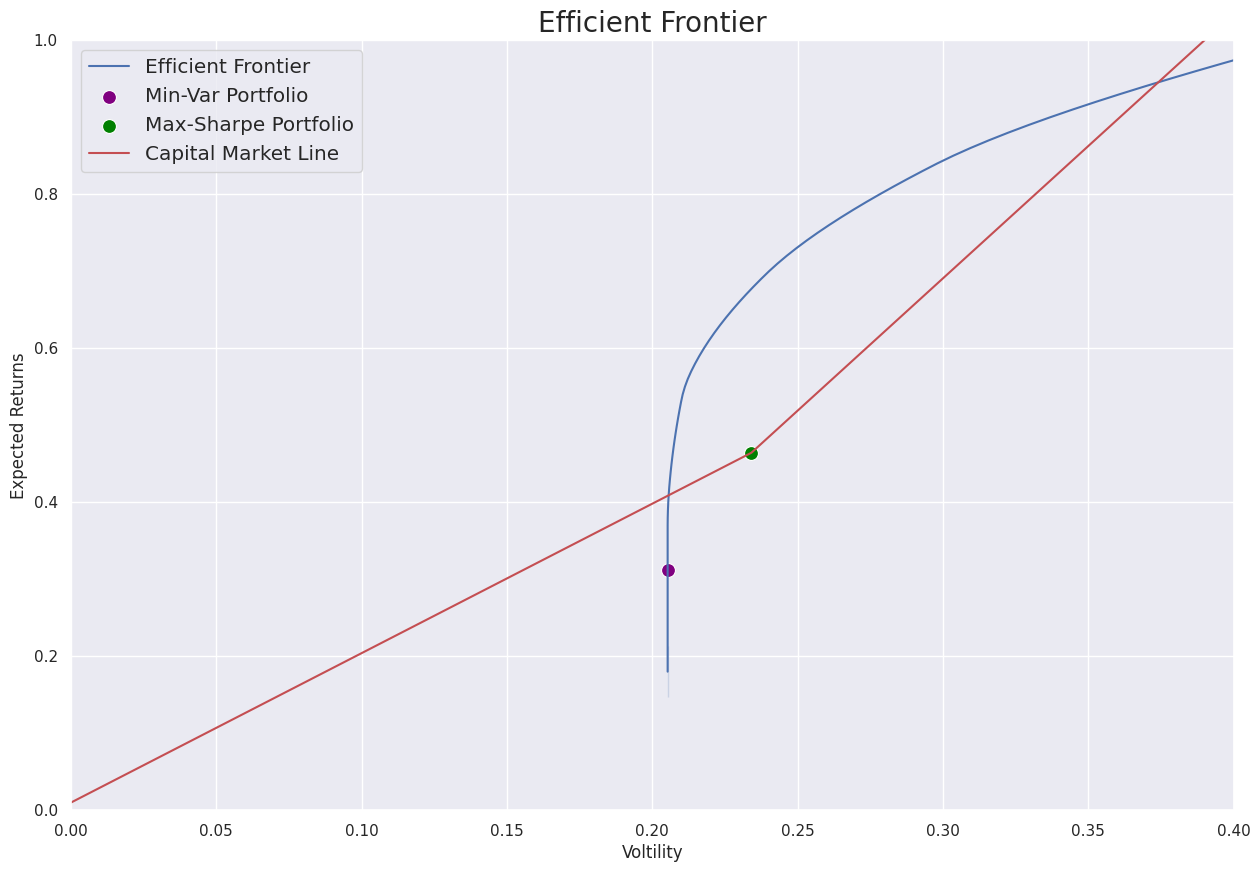

In [17]:
# efficient frontier - 위 코드에서 깔끔하게 주석을 뺀 코드
ret_ef = np.arange(0, 1, 0.01)
vol_ef = []

for i in np.arange(0, 1, 0.01):
    ef = EfficientFrontier(mu, Sigma)
    target_return = i * (ef.expected_returns.max() - ef.expected_returns.min()) + ef.expected_returns.min()
    ef = EfficientFrontier(mu, Sigma)  # EfficientFrontier 객체를 새로 생성
    ef.efficient_return(target_return)

    vol_ef.append(ef.portfolio_performance()[1])

ef = EfficientFrontier(mu, Sigma)
ef.min_volatility()
min_vol_ret = ef.portfolio_performance()[0]
min_vol_vol = ef.portfolio_performance()[1]

ef = EfficientFrontier(mu, Sigma)
ef.max_sharpe(risk_free_rate=0.01)
max_sharpe_ret = ef.portfolio_performance()[0]
max_sharpe_vol = ef.portfolio_performance()[1]

sns.set()
fig, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(x=vol_ef, y=ret_ef, ax=ax, label='Efficient Frontier')
sns.scatterplot(x=[min_vol_vol], y=[min_vol_ret], ax=ax, label='Min-Var Portfolio', color='purple', s=100)
sns.scatterplot(x=[max_sharpe_vol], y=[max_sharpe_ret], ax=ax, label='Max-Sharpe Portfolio', color='green', s=100)
sns.lineplot(x=[0, max_sharpe_vol, 1], y=[0.01, max_sharpe_ret, 3.096], label='Capital Market Line', ax=ax, color='r')

ax.set(xlim=[0, 0.4])
ax.set(ylim=[0, 1])
ax.set_xlabel('Voltility')
ax.set_ylabel('Expected Returns')
plt.legend(fontsize='large')
plt.title('Efficient Frontier', fontsize='20')

# ax.figure.savefig('EffFront_big.png', dpi=300)

In [54]:
np.array(vol_ef).max()

0.41846168114937926

In [55]:
max_sharpe_vol

0.23411618453546879

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning:

The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.



<Axes: >

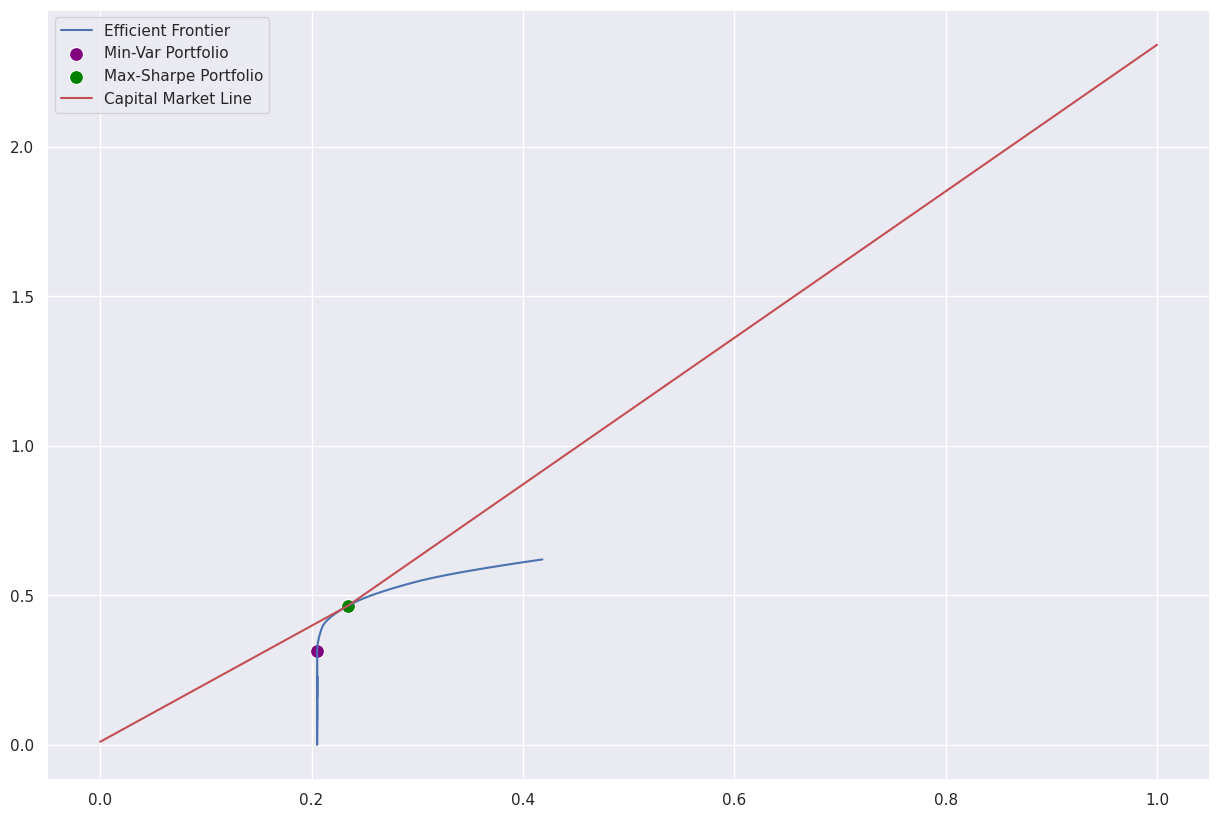

In [59]:
# efficient frontier
max_possible_return = mu.max()
ret_ef = np.arange(0, max_possible_return, 0.01)
vol_ef = []
ef = EfficientFrontier(mu, Sigma)  # 아래 for 문에 넣는 대신 이렇게 해도 되는 듯?

# 변동성에 따른 효율적인 포트폴리오 계산
for i in np.arange(0, max_possible_return, 0.01):
    # ef = EfficientFrontier(mu, Sigma)  # 주어진 평균 수익률(mu)과 공분산(Sigma)으로 EfficientFrontier 객체 생성
    ef.efficient_return(i)  # target return=i 에 대한 효율적인 포트폴리오 계산
    vol_ef.append(ef.portfolio_performance()[1])  # 계산된 포트폴리오의 변동성을 vol_ef 리스트에 추가

# Min-Variance 포트폴리오 계산
ef = EfficientFrontier(mu, Sigma)  # EfficientFrontier 객체 생성
ef.min_volatility()  # Min-Variance 포트폴리오 계산
min_vol_ret = ef.portfolio_performance()[0]  # Min-Variance 포트폴리오의 예상 수익률 저장
min_vol_vol = ef.portfolio_performance()[1]  # Min-Variance 포트폴리오의 변동성 저장

# Max-Sharpe ratio 포트폴리오 계산
ef = EfficientFrontier(mu, Sigma)
ef.max_sharpe(risk_free_rate=0.01)  # Max-Sharpe ratio 포트폴리오 계산
max_sharpe_ret = ef.portfolio_performance()[0]  # Max-Sharpe ratio 포트폴리오의 예상 수익률 저장
max_sharpe_vol = ef.portfolio_performance()[1]  # Max-Sharpe ratio 포트폴리오의 변동성 저장

# 그래프 생성과 시각화
sns.set()  # seaborn 설정
fig, ax = plt.subplots(figsize=(15,10))
sns.lineplot(x=vol_ef, y=ret_ef, ax=ax, label='Efficient Frontier')  # 효율적 포트폴리오 경계 그래프 생성
sns.scatterplot(x=[min_vol_vol], y=[min_vol_ret], ax=ax, label='Min-Var Portfolio', color='purple', s=100)  # Min-Variance 포트폴리오 그래프 생성
sns.scatterplot(x=[max_sharpe_vol], y=[max_sharpe_ret], ax=ax, label='Max-Sharpe Portfolio', color='green', s=100)  # Max-Sharpe ratio 포트폴리오 그래프 생성
sns.lineplot(x=[0, max_sharpe_vol, 1], y=[0.01, max_sharpe_ret, 2.3412], label='Capital Market Line', ax=ax, color='r')  # 자본 시장선 그래프 생성

# ax.set(xlim=[0, 0.4])  # x축 범위 설정
# ax.set(ylim=[0, 1])  # y축 범위 설정

Expected annual return: 31.2%
Annual volatility: 20.5%
Sharpe Ratio: 1.47


(0.31211673590632805, 0.20529683248106562, 1.4716093388055174)

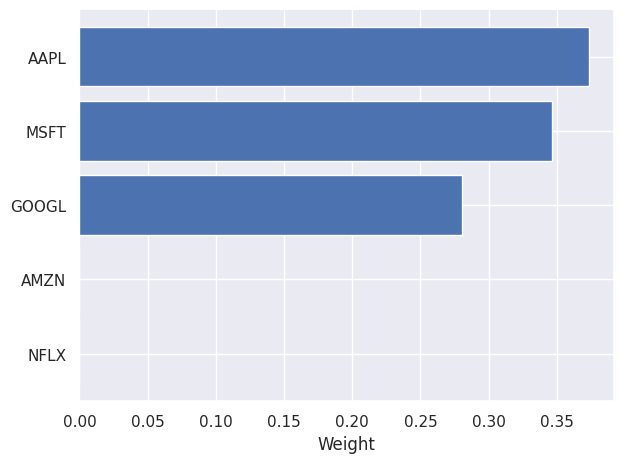

In [22]:
# min-variance portfolio
ef = EfficientFrontier(mu, Sigma)
raw_weights_minvar_exp = ef.min_volatility()

plot_weights(raw_weights_minvar_exp)
ef.portfolio_performance(verbose=True, risk_free_rate=0.01)

Expected annual return: 46.4%
Annual volatility: 23.4%
Sharpe Ratio: 1.94


(0.46429465660983443, 0.23411618453546879, 1.9404666854247679)

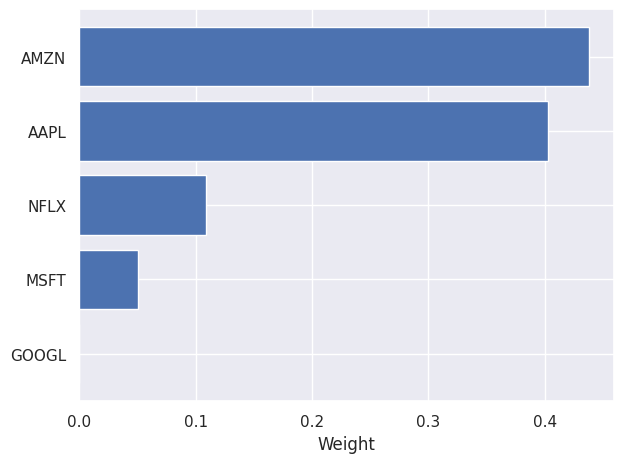

In [24]:
# max-Sharpe ratio portfolio
ef = EfficientFrontier(mu, Sigma)
raw_weights_maxsharpe_exp = ef.max_sharpe(risk_free_rate=0.01)

plot_weights(raw_weights_maxsharpe_exp)
ef.portfolio_performance(verbose=True, risk_free_rate=0.01)

### Backtesting

In [26]:
weights_minvar_exp = list(raw_weights_minvar_exp.values())
weights_maxsharpe_exp = list(raw_weights_maxsharpe_exp.values())

ret_minvar = test.dot(weights_minvar_exp).add(1).cumprod().subtract(1).multiply(100)
ret_maxsharpe = test.dot(weights_maxsharpe_exp).add(1).cumprod().subtract(1).multiply(100)
# recall cumrets_index = rets_index.add(1).cumprod().sub(1)*100

# backtesting via plotting
back = pd.DataFrame({'MinVar': ret_minvar, 'MaxSharpe': ret_maxsharpe})
back = pd.concat([back, cumrets_index], join='outer', axis=1)
back.drop(back.tail(1).index, inplace=True)

back.interpolate(method='linear', inplace=True)

fig = px.line(back, x=back.index, y=back.columns, title='Portfolio Performance (2010-2023.06)')
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Cumulative Return in %')
fig.show()